In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/CNN-DailyMail News.zip'

Archive:  /content/drive/MyDrive/CNN-DailyMail News.zip
  inflating: cnn_dailymail/test.csv  
  inflating: cnn_dailymail/train.csv  
  inflating: cnn_dailymail/validation.csv  


In [ ]:
#import all the required libraries
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#read the dataset file for text Summarizer
df=pd.read_csv("/content/cnn_dailymail/train.csv",nrows=30000)
#drop the duplicate and na values from the records
df.drop_duplicates(subset=['article'],inplace=True)
df.dropna(axis=0,inplace=True)
input_data = df.loc[:,'article']
target_data = df.loc[:,'highlights']
target_data.replace('', np.nan, inplace=True)

In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.6 MB/s eta 0:00:00


In [ ]:
input_texts=[]
target_texts=[]
input_words=[]
target_words=[]
contractions=pickle.load(open("/content/drive/MyDrive/contractions.pkl","rb"))['contractions']
#initialize stop words and LancasterStemmer
stop_words=set(stopwords.words('english'))
stemm=LancasterStemmer()

In [ ]:
def clean(texts,src):
  #remove the html tags
  texts = BeautifulSoup(texts, "lxml").text
  #tokenize the text into words
  words=word_tokenize(texts.lower())
  #filter words which contains \
  #integers or their length is less than or equal to 3
  words= list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
  #contraction file to expand shortened words
  words= [contractions[w] if w in contractions else w for w in words]
  #stem the words to their root word and filter stop words
  if src=="inputs":
    words= [stemm.stem(w) for w in words if w not in stop_words]
  else:
    words= [w for w in words if w not in stop_words]
  return words

In [ ]:
#pass the input records and taret records
for in_txt,tr_txt in zip(input_data,target_data):
  in_words= clean(in_txt,"inputs")
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  #add 'sos' at start and 'eos' at end of text
  tr_words= clean("sos "+tr_txt+" eos","target")
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words

<ipython-input-8-c3e4e6d64c21>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  texts = BeautifulSoup(texts, "lxml").text


In [ ]:
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words

#get the length of the input and target texts which appears most often
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])

print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  91859
number of target words :  51907
maximum input length :  1433
maximum target length :  194


In [ ]:
#split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0)

In [ ]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)

#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train)
y_train= tr_tokenizer.texts_to_sequences(y_train)

In [ ]:
#pad array of 0's if the length is less than the maximum length
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post')
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')

#decoder input data will not include the last word
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

In [ ]:
K.clear_session()
latent_dim = 10

#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,))
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs)

In [ ]:
#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True)
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding)

#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True)
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1)

#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)

#encoder states
en_states= [state_h3, state_c3]

In [ ]:
# Decoder.
dec_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_tr_words+1, latent_dim)
dec_embedding = dec_emb_layer(dec_inputs)

#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states)

In [ ]:
#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])

#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

In [ ]:
#Dense layer (output layer)
dec_dense = Dense(num_tr_words+1, activation='softmax')
dec_outputs = dec_dense(merge)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1433)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1433, 10)     918600      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 1433, 10),   840         ['embedding[0][0]']              
                                 (None, 10),                                                      
                                 (None, 10)]                                                      
                                                                                              

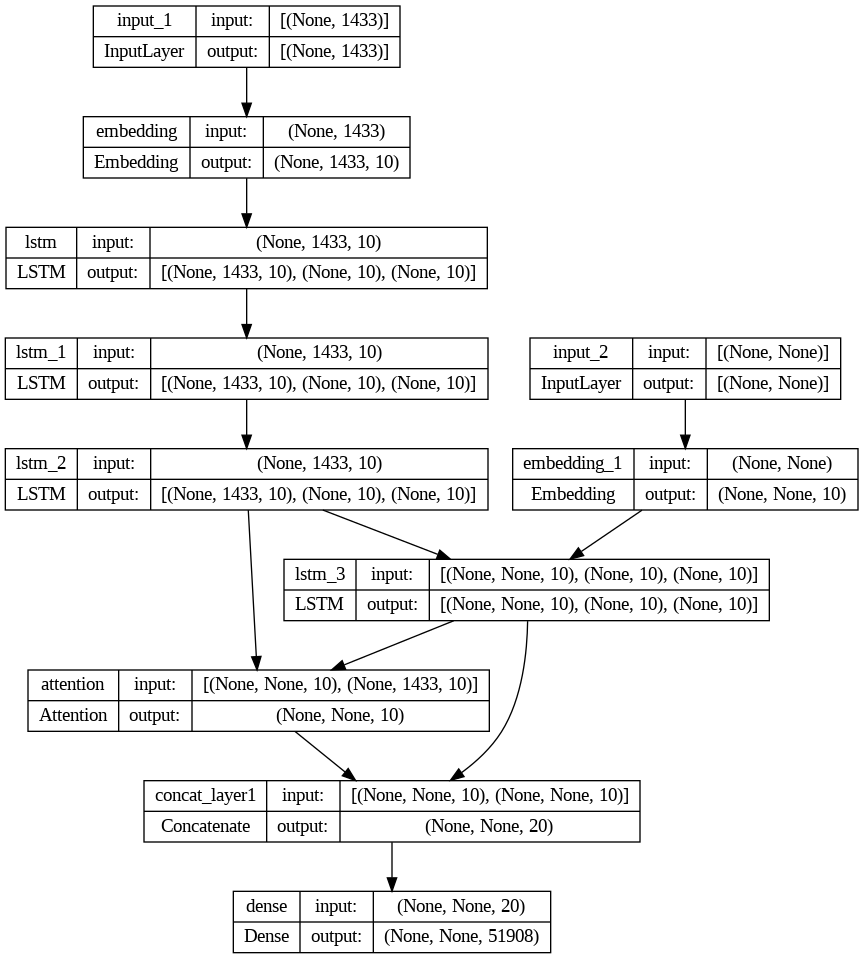

In [ ]:
#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
model.fit(
    [en_in_data, dec_in_data],
    dec_tr_data,
    batch_size=64,
    epochs=10,
    validation_split=0.1,
    )

#Save model
model.save("s2s.h5")

Epoch 1/10
338/338 [==============================] - 218s 629ms/step - loss: 1.3782 - accuracy: 0.8538 - val_loss: 1.3682 - val_accuracy: 0.8544
Epoch 2/10
338/338 [==============================] - 186s 551ms/step - loss: 1.3689 - accuracy: 0.8539 - val_loss: 1.3608 - val_accuracy: 0.8544
Epoch 3/10
338/338 [==============================] - 190s 561ms/step - loss: 1.3623 - accuracy: 0.8539 - val_loss: 1.3554 - val_accuracy: 0.8544
Epoch 4/10
338/338 [==============================] - 185s 547ms/step - loss: 1.3573 - accuracy: 0.8539 - val_loss: 1.3512 - val_accuracy: 0.8544
Epoch 5/10
338/338 [==============================] - 182s 539ms/step - loss: 1.3533 - accuracy: 0.8539 - val_loss: 1.3480 - val_accuracy: 0.8544
Epoch 6/10
338/338 [==============================] - 182s 538ms/step - loss: 1.3501 - accuracy: 0.8539 - val_loss: 1.3453 - val_accuracy: 0.8544
Epoch 7/10
338/338 [==============================] - 179s 531ms/step - loss: 1.3475 - accuracy: 0.8539 - val_loss: 1.3431 -

In [ ]:
# encoder inference
latent_dim=10
#/content/gdrive/MyDrive/Text Summarizer/
#load the model
model = models.load_model("s2s.h5")

#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

In [ ]:
# decoder inference
#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))

# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)

#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

In [ ]:
#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])

merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

In [ ]:
#Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)

# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

In [ ]:
import random  # Import the random module

#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index

def decode_sequence(input_seq):
    #get the encoder output and states by passing the input sequence
    en_out, en_h, en_c = en_model.predict(input_seq)

    #target sequence with initial word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']

    #if the iteration reaches the end of text, stop the iteration
    stop_condition = False
    #append every predicted word in decoded sentence
    decoded_sentence = ""

    while not stop_condition:
        #get predicted output, hidden and cell state.
        output_words, dec_h, dec_c = dec_model.predict([target_seq] + [en_out, en_h, en_c])

        # Sample a word based on the predicted probabilities distribution
        sampled_index = np.random.choice(len(output_words[0, -1, :]), p=output_words[0, -1, :])

        # Ensure the sampled index is within a valid range
        word_index = min(sampled_index, len(reverse_target_word_index) - 1)
        text_word = reverse_target_word_index[word_index]

        print(f"Sampled index: {sampled_index}, Word index: {word_index}, Text word: {text_word}")

        # Exit condition: either hit max length or find a stop word or last word.
        if text_word == "eos" or len(decoded_sentence.split()) > max_tr_len:
            stop_condition = True
        else:
            decoded_sentence += text_word + " "

        #update target sequence to the current word index.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c

    #return the decoded sentence
    return decoded_sentence.strip()


inp_review = input("Enter : ")
print("Review :", inp_review)
inp_review = clean(inp_review, "inputs")
print("Cleaned Input:", inp_review)
inp_review = ' '.join(inp_review)
print("Joined Input:", inp_review)
inp_x = in_tokenizer.texts_to_sequences([inp_review])
print("Texts to Sequences:", inp_x)
inp_x = pad_sequences(inp_x, maxlen=max_in_len, padding='post')
print("Padded Sequences:", inp_x)

summary = decode_sequence(inp_x)
if 'eos' in summary :
    summary = summary.replace('eos', '')
print("\nPredicted summary:", summary)


Enter : Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee. 'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowding on planes lead to more serious issues than fighting fo